In [1]:
"""
Complete DDQN Trading System for Jupyter Notebook
All modules combined into a single file
"""

import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
from typing import Dict, List, Tuple, Optional, Any
from sklearn.preprocessing import StandardScaler
from collections import deque
import random

warnings.filterwarnings('ignore')

In [2]:
# =============================================================================
# CONFIGURATION PARAMETERS
# =============================================================================

# Market parameters
TICK_VALUE = 10.0
MAX_CONTRACTS = 8
TRANSACTION_COST_PER_CONTRACT = 1.50
BID_ASK_SLIPPAGE = 1
SLIPPAGE_ENABLED = True

# Risk management
MAX_DAILY_LOSS = 500.0
STOP_LOSS_ENABLED = True
STOP_LOSS_PERCENTAGE = 0.1

# Data parameters
LOOKBACK_WINDOW = 50
MIN_LOOKBACK_FOR_TRAINING = 40
TRAIN_RATIO = 0.7
VAL_RATIO = 0.01
TEST_RATIO = 0.29

FEATURE_COLUMNS = [
   'PX_OPEN1', 'PX_HIGH1', 'PX_LOW1', 'PX_LAST1', 'PX_VOLUME1', 'OPEN_INT1',
   'PX_OPEN2', 'PX_HIGH2', 'PX_LOW2', 'PX_LAST2', 'PX_VOLUME2', 'OPEN_INT2',
   'VOL Change1', 'Vol Change %1', 'OI Change1', 'OI Change %1',
   'CALENDAR', 'Vol Ratio', 'Vol Ratio Change', 'OI Ratio', 'OI Ratio Change',
   'VOL Change2', 'Vol Change %2', 'OI Change2', 'OI Change %2'
]

TARGET_COLUMN = 'CALENDAR'
DATE_COLUMN = 'Dates'

# Goldman roll parameters
GOLDMAN_ROLL_START_DAY = 5
GOLDMAN_ROLL_END_DAY = 9
GOLDMAN_ROLL_WINDOW = 30

# LSTM parameters
LSTM_HIDDEN_SIZE = 200
LSTM_NUM_LAYERS = 3
LSTM_DROPOUT = 0.2
LSTM_BIDIRECTIONAL = False
LSTM_PROCESSING_DIM = 256
HIDDEN_DIMS = [512, 256, 128]

# DDQN parameters
LEARNING_RATE = 0.0001
GAMMA = 0.90 #How much future rewards matter
TAU = 0.05  #How fast the "teacher network" updates
BATCH_SIZE = 8 #How many past trades to learn from at once


# Action space
POSITION_ACTIONS = [-1.0, -0.5, 0.0, 0.5, 1.0]
ACTION_SPACE_SIZE = len(POSITION_ACTIONS)

# Reward function
REWARD_PNL_WEIGHT = 0.7
REWARD_WINRATE_WEIGHT = 0.2
REWARD_RISK_WEIGHT = 0.1
DRAWDOWN_PENALTY_THRESHOLD = 0.1
POSITION_SIZE_PENALTY = 0.01

# Training parameters
EPISODES = 2000
MEMORY_SIZE = 4000 #How many past trading experiences the agent remembers
UPDATE_FREQUENCY = 2 #How often the neural network actually trains
TARGET_UPDATE_FREQUENCY = 200 #How often the "teacher network" gets updated
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.999 #Reduce randomness by 0.1% each episode
PATIENCE = 50 #Early stopping threshold
MIN_IMPROVEMENT = 0.001

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_WORKERS = 4

# Logging
LOG_FREQUENCY = 10
SAVE_FREQUENCY = 250
MODEL_SAVE_PATH = "models/"
LOG_SAVE_PATH = "logs/"
RESULTS_SAVE_PATH = "results/"

# Backtesting
INITIAL_CAPITAL = 10000.0
TRACK_METRICS = [
   'total_return', 'sharpe_ratio', 'max_drawdown', 'win_rate',
   'profit_factor', 'total_trades', 'avg_trade_duration'
]

# Quick test
QUICK_TEST_MODE = False
QUICK_TEST_YEARS = 3
QUICK_TEST_EPISODES = 1000

# Plotting
PLOT_TRAINING_CURVES = True
PLOT_TRADING_RESULTS = True
SAVE_PLOTS = True

print(f"Configuration loaded successfully!")
print(f"Device: {DEVICE}")
print(f"Lookback window: {LOOKBACK_WINDOW} days")
print(f"Max contracts: {MAX_CONTRACTS}")
print(f"Tick value: ${TICK_VALUE}")
print(f"Quick test mode: {QUICK_TEST_MODE}")

Configuration loaded successfully!
Device: cuda
Lookback window: 50 days
Max contracts: 8
Tick value: $10.0
Quick test mode: False


In [3]:
# =============================================================================
# DATA HANDLER
# =============================================================================

class TradingDataHandler:
   def __init__(self, csv_path: str):
       self.csv_path = csv_path
       self.raw_data = None
       self.processed_data = None
       self.scaler = StandardScaler()
       self.feature_columns = FEATURE_COLUMNS
       self.date_column = DATE_COLUMN
       self.target_column = TARGET_COLUMN
       
   def load_data(self) -> pd.DataFrame:
       print(f"Loading data from {self.csv_path}...")
       
       column_names = [
           'PX_OPEN1', 'PX_HIGH1', 'PX_LOW1', 'PX_LAST1', 'PX_VOLUME1', 'OPEN_INT1',
           'PX_OPEN2', 'PX_HIGH2', 'PX_LOW2', 'PX_LAST2', 'PX_VOLUME2', 'OPEN_INT2',
           'Dates', 'VOL Change1', 'Vol Change %1', 'OI Change1', 'OI Change %1',
           'CALENDAR', 'Vol Ratio', 'Vol Ratio Change', 'OI Ratio', 'OI Ratio Change',
           'VOL Change2', 'Vol Change %2', 'OI Change2', 'OI Change %2'
           ]
       
       self.raw_data = pd.read_csv(self.csv_path, names=column_names, header=None, skiprows=3)
       
       self.raw_data['Dates'] = pd.to_datetime(self.raw_data['Dates'], dayfirst=True)
       self.raw_data = self.raw_data.sort_values('Dates').reset_index(drop=True)
       self.raw_data['date'] = self.raw_data['Dates']

       print(f"Loaded {len(self.raw_data)} rows of data")
       print(f"Date range: {self.raw_data['Dates'].min()} to {self.raw_data['Dates'].max()}")
       print(f"CALENDAR spread stats:")
       print(f"  Min: {self.raw_data['CALENDAR'].min()}")
       print(f"  Max: {self.raw_data['CALENDAR'].max()}")
       print(f"  Mean: {self.raw_data['CALENDAR'].mean()}")
       print(f"  Std: {self.raw_data['CALENDAR'].std()}")
       
       return self.raw_data
   
   def calculate_business_day_features(self, df: pd.DataFrame) -> pd.DataFrame:
       df = df.copy()
       
       df['business_day_of_month'] = df['Dates'].apply(self._get_business_day_of_month)
       
       df['days_to_roll_start'] = df['business_day_of_month'].apply(
           lambda x: max(0, GOLDMAN_ROLL_START_DAY - x) if x < GOLDMAN_ROLL_START_DAY 
           else 0
       )
       
       df['days_since_roll_end'] = df['business_day_of_month'].apply(
           lambda x: max(0, x - GOLDMAN_ROLL_END_DAY) if x > GOLDMAN_ROLL_END_DAY 
           else 0
       )
       
       df['in_goldman_roll'] = (
           (df['business_day_of_month'] >= GOLDMAN_ROLL_START_DAY) & 
           (df['business_day_of_month'] <= GOLDMAN_ROLL_END_DAY)
       ).astype(int)
       
       df['in_extended_roll_window'] = (
           (df['business_day_of_month'] >= GOLDMAN_ROLL_START_DAY - 5) & 
           (df['business_day_of_month'] <= GOLDMAN_ROLL_END_DAY + 5)
       ).astype(int)
       
       return df
   
   def _get_business_day_of_month(self, date: datetime) -> int:
       first_day = date.replace(day=1)
       business_days = 0
       current_date = first_day
       
       while current_date <= date:
           if current_date.weekday() < 5:
               business_days += 1
           current_date += timedelta(days=1)
           
       return business_days
   
   def engineer_features(self, df: pd.DataFrame) -> pd.DataFrame:
       df = df.copy()
   
       df['front_hl_ratio'] = df['PX_HIGH1'] / df['PX_LOW1']
       df['second_hl_ratio'] = df['PX_HIGH2'] / df['PX_LOW2']
       df['front_close_position'] = (df['PX_LAST1'] - df['PX_LOW1']) / (df['PX_HIGH1'] - df['PX_LOW1'])
       df['second_close_position'] = (df['PX_LAST2'] - df['PX_LOW2']) / (df['PX_HIGH2'] - df['PX_LOW2'])

       df['volume_momentum'] = df['Vol Ratio'].rolling(5).mean()
       df['oi_momentum'] = df['OI Ratio'].rolling(5).mean()

       df['spread_momentum_5'] = df['CALENDAR'].rolling(5).mean()
       df['spread_momentum_10'] = df['CALENDAR'].rolling(10).mean()
       df['spread_volatility'] = df['CALENDAR'].rolling(10).std()

       df['front_vs_second_strength'] = df['PX_LAST1'] / df['PX_LAST2']
   
       return df
   
   def preprocess_data(self) -> pd.DataFrame:
       if self.raw_data is None:
           self.load_data()
           
       df = self.raw_data.copy()
       
       df = df.fillna(method='ffill').fillna(method='bfill')
       df = self.calculate_business_day_features(df)
       df = self.engineer_features(df)
       df = df.dropna()
       
       self.processed_data = df
       print(f"Preprocessing complete. Final dataset: {len(df)} rows")
       
       return df
   
   def create_sequences(self, df: pd.DataFrame, lookback: int = None) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
       if lookback is None:
           lookback = LOOKBACK_WINDOW
       
       feature_cols = [col for col in df.columns if col not in ['date', 'Dates']]
       feature_cols = [col for col in feature_cols if not col.startswith('business_day')]
       feature_cols = [col for col in feature_cols if not col.startswith('days_')]
       feature_cols = [col for col in feature_cols if not col.startswith('in_goldman')]
       feature_cols = [col for col in feature_cols if not col.startswith('in_extended')]
   
       print(f"Using {len(feature_cols)} features for training")
       print(f"Features: {feature_cols}...")
   
       feature_data = self.scaler.fit_transform(df[feature_cols])
   
       sequences = []
       targets = []
       dates = []
   
       for i in range(lookback, len(df)):
           sequence = feature_data[i-lookback:i].T
           sequences.append(sequence)
           targets.append(df.iloc[i][self.target_column])
           dates.append(df.iloc[i]['Dates'])
   
       return np.array(sequences), np.array(targets), np.array(dates)
   
   def split_data(self, sequences: np.ndarray, targets: np.ndarray, dates: np.ndarray, 
                  quick_test: bool = False) -> Dict:
       
       if quick_test:
           n_years = QUICK_TEST_YEARS
           cutoff_date = dates[-1] - pd.DateOffset(years=n_years)
           mask = pd.to_datetime(dates) >= cutoff_date
           
           sequences = sequences[mask]
           targets = targets[mask]
           dates = dates[mask]
           
       n_samples = len(sequences)
       
       train_end = int(n_samples * TRAIN_RATIO)
       val_end = int(n_samples * (TRAIN_RATIO + VAL_RATIO))
       
       data_splits = {
           'train': {
               'sequences': sequences[:train_end],
               'targets': targets[:train_end],
               'dates': dates[:train_end]
           },
           'val': {
               'sequences': sequences[train_end:val_end],
               'targets': targets[train_end:val_end],
               'dates': dates[train_end:val_end]
           },
           'test': {
               'sequences': sequences[val_end:],
               'targets': targets[val_end:],
               'dates': dates[val_end:]
           }
       }
       
       print(f"Data splits:")
       print(f"  Train: {len(data_splits['train']['sequences'])} samples")
       print(f"  Validation: {len(data_splits['val']['sequences'])} samples") 
       print(f"  Test: {len(data_splits['test']['sequences'])} samples")
       
       return data_splits
   
   def get_feature_info(self) -> Dict:
       if self.processed_data is None:
           self.preprocess_data()
           
       feature_cols = [col for col in self.processed_data.columns if col not in ['date']]
       
       return {
           'n_features': len(feature_cols),
           'feature_names': feature_cols,
           'n_samples': len(self.processed_data),
           'date_range': (self.processed_data['date'].min(), self.processed_data['date'].max())
       }


In [4]:
# =============================================================================
# NEURAL NETWORKS
# =============================================================================

class LSTMFeatureExtractor(nn.Module):
   def __init__(self, n_features: int, sequence_length: int):
       super(LSTMFeatureExtractor, self).__init__()
       
       self.n_features = n_features
       self.sequence_length = sequence_length
       
       self.hidden_size = LSTM_HIDDEN_SIZE
       self.num_layers = LSTM_NUM_LAYERS
       self.dropout = LSTM_DROPOUT
       
       self.lstm = nn.LSTM(
           input_size=n_features,
           hidden_size=self.hidden_size,
           num_layers=self.num_layers,
           dropout=self.dropout if self.num_layers > 1 else 0,
           batch_first=True,
           bidirectional=LSTM_BIDIRECTIONAL
       )
       
       self.lstm_output_size = self.hidden_size * (2 if LSTM_BIDIRECTIONAL else 1)
       
       self.feature_processor = nn.Sequential(
           nn.Linear(self.lstm_output_size, LSTM_PROCESSING_DIM),
           nn.ReLU(),
           nn.Dropout(LSTM_DROPOUT),
           nn.Linear(LSTM_PROCESSING_DIM, LSTM_PROCESSING_DIM // 2),
           nn.ReLU(),
           nn.Dropout(LSTM_DROPOUT)
       )
       
       self.output_dim = LSTM_PROCESSING_DIM // 2
       
   def forward(self, x):
       batch_size = x.size(0)
       h0 = torch.zeros(
           self.num_layers * (2 if LSTM_BIDIRECTIONAL else 1),
           batch_size,
           self.hidden_size,
           device=x.device
       )
       c0 = torch.zeros(
           self.num_layers * (2 if LSTM_BIDIRECTIONAL else 1),
           batch_size,
           self.hidden_size,
           device=x.device
       )
       
       lstm_out, (hn, cn) = self.lstm(x, (h0, c0))
       final_output = lstm_out[:, -1, :]
       features = self.feature_processor(final_output)
       
       return features

class DQNNetwork(nn.Module):
   def __init__(self, market_feature_dim: int, trading_state_dim: int, 
                action_space_size: int, sequence_length: int):
       super(DQNNetwork, self).__init__()
       
       self.market_feature_dim = market_feature_dim
       self.trading_state_dim = trading_state_dim
       self.action_space_size = action_space_size
       
       self.lstm = LSTMFeatureExtractor(market_feature_dim, sequence_length)
       
       total_input_dim = self.lstm.output_dim + trading_state_dim
       
       self.fc_layers = nn.ModuleList()
       
       self.fc_layers.append(nn.Linear(total_input_dim, HIDDEN_DIMS[0]))
       
       for i in range(1, len(HIDDEN_DIMS)):
           self.fc_layers.append(
               nn.Linear(HIDDEN_DIMS[i-1], HIDDEN_DIMS[i])
           )
       
       self.q_values = nn.Linear(HIDDEN_DIMS[-1], action_space_size)
       
       self.dropout = nn.Dropout(LSTM_DROPOUT)
       
       self._initialize_weights()
   
   def _initialize_weights(self):
       for module in self.modules():
           if isinstance(module, nn.Linear):
               nn.init.xavier_uniform_(module.weight)
               if module.bias is not None:
                   nn.init.constant_(module.bias, 0)
           elif isinstance(module, nn.LSTM):
               for name, param in module.named_parameters():
                   if 'weight_ih' in name:
                       nn.init.xavier_uniform_(param.data)
                   elif 'weight_hh' in name:
                       nn.init.orthogonal_(param.data)
                   elif 'bias' in name:
                       param.data.fill_(0)
   
   def forward(self, market_features, trading_state):
       lstm_features = self.lstm(market_features)
       
       combined_features = torch.cat([lstm_features, trading_state], dim=1)
       
       x = combined_features
       for fc_layer in self.fc_layers:
           x = fc_layer(x)
           x = F.relu(x)
           x = self.dropout(x)
       
       q_values = self.q_values(x)
       
       return q_values

class DoubleDQN(nn.Module):
   def __init__(self, market_feature_dim: int, trading_state_dim: int,
                action_space_size: int, sequence_length: int):
       super(DoubleDQN, self).__init__()
       
       self.online_net = DQNNetwork(
           market_feature_dim, trading_state_dim, action_space_size, sequence_length
       )
       
       self.target_net = DQNNetwork(
           market_feature_dim, trading_state_dim, action_space_size, sequence_length
       )
       
       self.update_target_network()
       
       for param in self.target_net.parameters():
           param.requires_grad = False
   
   def forward(self, market_features, trading_state, use_target=False):
       if use_target:
           return self.target_net(market_features, trading_state)
       else:
           return self.online_net(market_features, trading_state)
   
   def update_target_network(self, tau: float = None):
       if tau is None:
           self.target_net.load_state_dict(self.online_net.state_dict())
       else:
           for target_param, online_param in zip(
               self.target_net.parameters(), self.online_net.parameters()
           ):
               target_param.data.copy_(
                   tau * online_param.data + (1.0 - tau) * target_param.data
               )
   
   def get_action(self, market_features, trading_state, epsilon=0.0):
       if np.random.random() < epsilon:
           return np.random.randint(0, self.online_net.action_space_size)
       else:
           with torch.no_grad():
               q_values = self.online_net(market_features, trading_state)
               return q_values.argmax().item()

class ReplayBuffer:
   def __init__(self, capacity: int):
       self.capacity = capacity
       self.buffer = []
       self.position = 0
   
   def push(self, market_features, trading_state, action, reward, 
            next_market_features, next_trading_state, done):
       if len(self.buffer) < self.capacity:
           self.buffer.append(None)
       
       self.buffer[self.position] = (
           market_features, trading_state, action, reward,
           next_market_features, next_trading_state, done
       )
       self.position = (self.position + 1) % self.capacity
   
   def sample(self, batch_size: int):
       batch = np.random.choice(len(self.buffer), batch_size, replace=False)
       
       market_features = []
       trading_states = []
       actions = []
       rewards = []
       next_market_features = []
       next_trading_states = []
       dones = []
       
       for idx in batch:
           mf, ts, a, r, nmf, nts, d = self.buffer[idx]
           market_features.append(mf)
           trading_states.append(ts)
           actions.append(a)
           rewards.append(r)
           next_market_features.append(nmf)
           next_trading_states.append(nts)
           dones.append(d)
       
       return (
           torch.FloatTensor(market_features),
           torch.FloatTensor(trading_states),
           torch.LongTensor(actions),
           torch.FloatTensor(rewards),
           torch.FloatTensor(next_market_features),
           torch.FloatTensor(next_trading_states),
           torch.BoolTensor(dones)
       )
   
   def __len__(self):
       return len(self.buffer)

def save_model(model: DoubleDQN, filepath: str, optimizer_state: dict = None, 
              metadata: dict = None):
   checkpoint = {
       'online_net_state_dict': model.online_net.state_dict(),
       'target_net_state_dict': model.target_net.state_dict(),
   }
   
   if optimizer_state:
       checkpoint['optimizer_state_dict'] = optimizer_state
   
   if metadata:
       checkpoint['metadata'] = metadata
   
   torch.save(checkpoint, filepath)
   print(f"Model saved to {filepath}")

def load_model(model: DoubleDQN, filepath: str, load_optimizer: bool = False):
   checkpoint = torch.load(filepath, map_location=DEVICE)
   
   model.online_net.load_state_dict(checkpoint['online_net_state_dict'])
   model.target_net.load_state_dict(checkpoint['target_net_state_dict'])
   
   optimizer_state = None
   if load_optimizer and 'optimizer_state_dict' in checkpoint:
       optimizer_state = checkpoint['optimizer_state_dict']
   
   metadata = checkpoint.get('metadata', {})
   
   print(f"Model loaded from {filepath}")
   return optimizer_state, metadata

In [5]:
# =============================================================================
# TRADING ENVIRONMENT
# =============================================================================

class TradingEnvironment:
   def __init__(self, data_sequences: np.ndarray, data_targets: np.ndarray, 
                data_dates: np.ndarray, initial_capital: float = None):
       self.data_sequences = data_sequences
       self.data_targets = data_targets
       self.data_dates = data_dates
       self.n_samples = len(data_sequences)
       
       self.initial_capital = initial_capital or INITIAL_CAPITAL
       self.tick_value = TICK_VALUE
       self.max_contracts = MAX_CONTRACTS
       self.transaction_cost = TRANSACTION_COST_PER_CONTRACT
       self.slippage = BID_ASK_SLIPPAGE if SLIPPAGE_ENABLED else 0.0
       
       self.max_daily_loss = MAX_DAILY_LOSS
       self.stop_loss_enabled = STOP_LOSS_ENABLED
       self.stop_loss_pct = STOP_LOSS_PERCENTAGE
       
       self.reset()
       
   def reset(self) -> np.ndarray:
       self.current_step = 0
       self.position = 0
       self.cash = self.initial_capital
       self.total_pnl = 0.0
       self.unrealized_pnl = 0.0
       self.daily_pnl = 0.0
       
       self.trade_history = []
       self.equity_curve = [self.initial_capital]
       self.daily_returns = []
       self.max_drawdown = 0.0
       self.peak_equity = self.initial_capital
       
       self.total_trades = 0
       self.winning_trades = 0
       self.losing_trades = 0
       self.current_trade_entry_price = None
       self.current_trade_entry_step = None
       
       self.daily_loss_tracker = 0.0
       self.stop_loss_triggered = False
       
       return self._get_state()
   
   def _get_state(self) -> np.ndarray:
       if self.current_step >= self.n_samples:
           market_features = np.zeros((self.data_sequences.shape[1], self.data_sequences.shape[2]))
       else:
           market_features = self.data_sequences[self.current_step]
       
       market_state = market_features.flatten()
       
       trading_state = np.array([
           self.position / self.max_contracts,
           self.unrealized_pnl / self.initial_capital,
           self.total_pnl / self.initial_capital,
           self.daily_pnl / self.initial_capital,
           (self.cash + self.unrealized_pnl) / self.initial_capital,
           self.max_drawdown,
           float(self.stop_loss_triggered),
           self.current_step / self.n_samples,
       ])
       
       return np.concatenate([market_state, trading_state])
   
   def step(self, action: int) -> Tuple[np.ndarray, float, bool, Dict]:
       if self.current_step >= self.n_samples - 1:
           return self._get_state(), 0.0, True, {'reason': 'end_of_data'}
       
       current_price = self.data_targets[self.current_step]
       next_price = self.data_targets[self.current_step + 1]

       oi_ratio_feature_index = 15
       self.current_oi_ratio = self.data_sequences[self.current_step][oi_ratio_feature_index][-1]
       
       position_change_pct = POSITION_ACTIONS[action]
       position_change = int(position_change_pct * self.max_contracts)
       
       new_position = np.clip(
           self.position + position_change, 
           -self.max_contracts, 
           self.max_contracts
       )
       actual_position_change = new_position - self.position
       
       transaction_cost = abs(actual_position_change) * self.transaction_cost
       slippage_cost = abs(actual_position_change) * self.slippage * self.tick_value
       total_cost = transaction_cost + slippage_cost
       
       self.position = new_position
       self.cash -= total_cost
       
       self.current_step += 1
       
       if self.position != 0:
           price_change = next_price - current_price
           position_pnl = self.position * price_change * self.tick_value
           self.unrealized_pnl += position_pnl
           self.daily_pnl += position_pnl
       
       if actual_position_change != 0 and self.current_trade_entry_price is not None:
           if self.position == 0:
               self._record_trade()
       
       if self.position != 0 and self.current_trade_entry_price is None:
           self.current_trade_entry_price = current_price
           self.current_trade_entry_step = self.current_step
       
       current_equity = self.cash + self.unrealized_pnl
       self.equity_curve.append(current_equity)
       
       if current_equity > self.peak_equity:
           self.peak_equity = current_equity
       
       current_drawdown = (self.peak_equity - current_equity) / self.peak_equity
       self.max_drawdown = max(self.max_drawdown, current_drawdown)
       
       done = False
       info = {}
       
       if self.daily_pnl < -self.max_daily_loss:
           done = True
           info['reason'] = 'daily_loss_limit'
           self.stop_loss_triggered = True
       
       if self.stop_loss_enabled and current_drawdown > self.stop_loss_pct:
           done = True
           info['reason'] = 'stop_loss'
           self.stop_loss_triggered = True
       
       reward = self._calculate_reward()
       
       if self.current_step % 1 == 0:
           self.daily_pnl = 0.0
       
       next_state = self._get_state()
       
       info.update({
           'position': self.position,
           'cash': self.cash,
           'unrealized_pnl': self.unrealized_pnl,
           'total_pnl': self.total_pnl,
           'equity': current_equity,
           'drawdown': current_drawdown,
           'transaction_cost': total_cost,
           'current_price': next_price
       })
       
       return next_state, reward, done, info
   
   def _calculate_reward(self) -> float:
    """Calculate reward based on multiple factors"""
    current_equity = self.cash + self.unrealized_pnl
    
    # P&L component (normalized by initial capital)
    pnl_reward = self.daily_pnl / self.initial_capital

    # Win rate component
    win_rate = self.winning_trades / max(1, self.total_trades)
    win_rate_reward = (win_rate - 0.5) * 2

    # OI Ratio constraint penalty - INITIALIZE FIRST
    oi_penalty = 0.0
    if hasattr(self, 'current_oi_ratio') and self.current_oi_ratio >= 1.5:
        if self.position != 0:
            oi_penalty = 5.0  # Strong penalty for trading when OI ratio >= 1.5
        else:
            oi_penalty = -1  # Small bonus for staying flat when OI ratio >= 1.5
    if hasattr(self, 'current_oi_ratio') and self.current_oi_ratio < 0.9:
        if self.position != 0:
            oi_penalty -= 2.0  # Bonus for trading when OI ratio < 0.8 (good time)

    # Risk penalty component - INITIALIZE FIRST
    risk_penalty = 0.0
    if self.max_drawdown > DRAWDOWN_PENALTY_THRESHOLD:
        risk_penalty += (self.max_drawdown - DRAWDOWN_PENALTY_THRESHOLD) * 10

    # Combine components
    reward = (
        REWARD_PNL_WEIGHT * pnl_reward +
        REWARD_WINRATE_WEIGHT * win_rate_reward -
        REWARD_RISK_WEIGHT * risk_penalty -
        oi_penalty  # Subtract OI penalty
    )   

    return reward
   
   def _record_trade(self):
       if self.current_trade_entry_price is None:
           return
           
       current_price = self.data_targets[self.current_step]
       trade_pnl = (current_price - self.current_trade_entry_price) * self.position * self.tick_value
       
       self.total_trades += 1
       
       if trade_pnl > 0:
           self.winning_trades += 1
       else:
           self.losing_trades += 1
       
       trade_info = {
           'entry_price': self.current_trade_entry_price,
           'exit_price': current_price,
           'entry_step': self.current_trade_entry_step,
           'exit_step': self.current_step,
           'position': self.position,
           'pnl': trade_pnl,
           'duration': self.current_step - self.current_trade_entry_step
       }
       
       self.trade_history.append(trade_info)
       self.total_pnl += trade_pnl
       
       self.current_trade_entry_price = None
       self.current_trade_entry_step = None
   
   def get_performance_metrics(self) -> Dict:
       if len(self.equity_curve) < 2:
           return {}
       
       returns = np.diff(self.equity_curve) / self.equity_curve[:-1]
       total_return = (self.equity_curve[-1] - self.initial_capital) / self.initial_capital
       
       if len(returns) > 1 and np.std(returns) > 0:
           sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(252)
       else:
           sharpe_ratio = 0.0
       
       win_rate = self.winning_trades / max(1, self.total_trades)
       
       if self.losing_trades > 0:
           winning_pnl = sum([trade['pnl'] for trade in self.trade_history if trade['pnl'] > 0])
           losing_pnl = abs(sum([trade['pnl'] for trade in self.trade_history if trade['pnl'] < 0]))
           profit_factor = winning_pnl / losing_pnl if losing_pnl > 0 else float('inf')
       else:
           profit_factor = float('inf') if self.winning_trades > 0 else 0.0
       
       if self.trade_history:
           avg_trade_duration = np.mean([trade['duration'] for trade in self.trade_history])
       else:
           avg_trade_duration = 0.0
       
       return {
           'total_return': total_return,
           'sharpe_ratio': sharpe_ratio,
           'max_drawdown': self.max_drawdown,
           'win_rate': win_rate,
           'profit_factor': profit_factor,
           'total_trades': self.total_trades,
           'winning_trades': self.winning_trades,
           'losing_trades': self.losing_trades,
           'avg_trade_duration': avg_trade_duration,
           'final_equity': self.equity_curve[-1],
           'total_pnl': self.total_pnl,
           'unrealized_pnl': self.unrealized_pnl
       }
   
   def get_action_space_size(self) -> int:
       return len(POSITION_ACTIONS)
   
   def get_state_size(self) -> int:
       if self.current_step < self.n_samples:
           market_features = self.data_sequences[self.current_step].flatten()
       else:
           market_features = np.zeros((self.data_sequences.shape[1] * self.data_sequences.shape[2]))
       
       trading_features = 8
       return len(market_features) + trading_features
   
   def render(self, mode='human'):
       if mode == 'human':
           print(f"Step: {self.current_step}")
           print(f"Position: {self.position} contracts")
           print(f"Cash: ${self.cash:,.2f}")
           print(f"Unrealized P&L: ${self.unrealized_pnl:,.2f}")
           print(f"Total P&L: ${self.total_pnl:,.2f}")
           print(f"Equity: ${self.cash + self.unrealized_pnl:,.2f}")
           print(f"Drawdown: {self.max_drawdown:.2%}")
           print(f"Trades: {self.total_trades} (Win Rate: {self.winning_trades/max(1,self.total_trades):.1%})")
           print("-" * 50)

class TradingEnvironmentWrapper:
   def __init__(self, data_splits: Dict):
       self.data_splits = data_splits
       
   def create_env(self, split: str = 'train') -> TradingEnvironment:
       if split not in self.data_splits:
           raise ValueError(f"Split '{split}' not found. Available: {list(self.data_splits.keys())}")
       
       data = self.data_splits[split]
       return TradingEnvironment(
           data_sequences=data['sequences'],
           data_targets=data['targets'],
           data_dates=data['dates']
       )
   
   def get_env_info(self) -> Dict:
       info = {}
       for split in self.data_splits:
           env = self.create_env(split)
           info[split] = {
               'n_samples': env.n_samples,
               'state_size': env.get_state_size(),
               'action_space_size': env.get_action_space_size(),
               'date_range': (env.data_dates[0], env.data_dates[-1])
           }
       return info


In [6]:
# =============================================================================
# DDQN AGENT
# =============================================================================

class DDQNTradingAgent:
   def __init__(self, market_feature_dim: int, trading_state_dim: int, 
                action_space_size: int, lookback_window: int):
       self.market_feature_dim = market_feature_dim
       self.trading_state_dim = trading_state_dim
       self.action_space_size = action_space_size
       self.lookback_window = lookback_window
       
       self.ddqn = DoubleDQN(
           market_feature_dim, trading_state_dim, action_space_size, lookback_window
       ).to(DEVICE)
       
       self.optimizer = optim.Adam(
           self.ddqn.online_net.parameters(), 
           lr=LEARNING_RATE
       )
       
       self.criterion = nn.MSELoss()
       
       self.replay_buffer = ReplayBuffer(MEMORY_SIZE)
       
       self.epsilon = EPSILON_START
       self.epsilon_min = EPSILON_END
       self.epsilon_decay = EPSILON_DECAY
       self.gamma = GAMMA
       self.tau = TAU
       self.batch_size = BATCH_SIZE
       self.update_frequency = UPDATE_FREQUENCY
       self.target_update_frequency = TARGET_UPDATE_FREQUENCY
       
       self.training_step = 0
       self.episode_rewards = []
       self.episode_losses = []
       self.episode_epsilons = []
       self.training_metrics = {
           'rewards': [],
           'losses': [],
           'epsilons': [],
           'q_values': [],
           'actions_taken': []
       }
       
       print(f"DDQN Agent initialized with {self._count_parameters()} parameters")
       print(f"Device: {DEVICE}")
   
   def _count_parameters(self) -> int:
       return sum(p.numel() for p in self.ddqn.online_net.parameters() if p.requires_grad)
   
   def _state_to_tensors(self, state: np.ndarray) -> Tuple[torch.Tensor, torch.Tensor]:
       market_size = self.market_feature_dim * self.lookback_window
       market_features = state[:market_size].reshape(self.market_feature_dim, self.lookback_window)
       trading_state = state[market_size:]
       
       market_tensor = torch.FloatTensor(market_features).permute(1, 0).unsqueeze(0).to(DEVICE)
       trading_tensor = torch.FloatTensor(trading_state).unsqueeze(0).to(DEVICE)
       
       return market_tensor, trading_tensor
   
   def get_action(self, state: np.ndarray, training: bool = True) -> int:
       if training and random.random() < self.epsilon:
           action = random.randint(0, self.action_space_size - 1)
           self.training_metrics['actions_taken'].append(('random', action))
       else:
           market_features, trading_state = self._state_to_tensors(state)
           
           with torch.no_grad():
               q_values = self.ddqn(market_features, trading_state, use_target=False)
               action = q_values.argmax().item()
               
               if training:
                   self.training_metrics['q_values'].append(q_values.cpu().numpy()[0])
                   self.training_metrics['actions_taken'].append(('greedy', action))
       
       return action
   
   def store_transition(self, state: np.ndarray, action: int, reward: float,
                       next_state: np.ndarray, done: bool):
       market_features, trading_state = self._state_to_tensors(state)
       next_market_features, next_trading_state = self._state_to_tensors(next_state)
       
       self.replay_buffer.push(
           market_features.squeeze(0).cpu().numpy(),
           trading_state.squeeze(0).cpu().numpy(),
           action,
           reward,
           next_market_features.squeeze(0).cpu().numpy(),
           next_trading_state.squeeze(0).cpu().numpy(),
           done
       )
   
   def train_step(self) -> float:
       if len(self.replay_buffer) < self.batch_size:
           return 0.0
       
       batch = self.replay_buffer.sample(self.batch_size)
       market_features, trading_states, actions, rewards, next_market_features, next_trading_states, dones = batch
       
       market_features = market_features.to(DEVICE)
       trading_states = trading_states.to(DEVICE)
       actions = actions.to(DEVICE)
       rewards = rewards.to(DEVICE)
       next_market_features = next_market_features.to(DEVICE)
       next_trading_states = next_trading_states.to(DEVICE)
       dones = dones.to(DEVICE)
       
       current_q_values = self.ddqn(market_features, trading_states, use_target=False)
       current_q_values = current_q_values.gather(1, actions.unsqueeze(1)).squeeze(1)
       
       with torch.no_grad():
           next_q_values_online = self.ddqn(next_market_features, next_trading_states, use_target=False)
           next_actions = next_q_values_online.argmax(1)
           
           next_q_values_target = self.ddqn(next_market_features, next_trading_states, use_target=True)
           next_q_values = next_q_values_target.gather(1, next_actions.unsqueeze(1)).squeeze(1)
           
           target_q_values = rewards + (self.gamma * next_q_values * ~dones)
       
       loss = self.criterion(current_q_values, target_q_values)
       
       self.optimizer.zero_grad()
       loss.backward()
       
       torch.nn.utils.clip_grad_norm_(self.ddqn.online_net.parameters(), 1.0)
       
       self.optimizer.step()
       
       if self.training_step % self.target_update_frequency == 0:
           self.ddqn.update_target_network(self.tau)
       
       if self.epsilon > self.epsilon_min:
           self.epsilon *= self.epsilon_decay
       
       self.training_step += 1
       
       return loss.item()
   
   def train_episode(self, env, episode: int) -> Dict:
       state = env.reset()
       total_reward = 0.0
       total_loss = 0.0
       steps = 0
       episode_actions = []
       
       while True:
           action = self.get_action(state, training=True)
           episode_actions.append(action)
           
           next_state, reward, done, info = env.step(action)
           
           self.store_transition(state, action, reward, next_state, done)
           
           if len(self.replay_buffer) >= self.batch_size and steps % self.update_frequency == 0:
               loss = self.train_step()
               total_loss += loss
           
           total_reward += reward
           steps += 1
           state = next_state
           
           if done:
               break
       
       episode_metrics = {
           'episode': episode,
           'total_reward': total_reward,
           'average_loss': total_loss / max(1, steps // self.update_frequency),
           'steps': steps,
           'epsilon': self.epsilon,
           'actions': episode_actions,
           'final_performance': env.get_performance_metrics()
       }
       
       self.episode_rewards.append(total_reward)
       self.episode_losses.append(total_loss / max(1, steps // self.update_frequency))
       self.episode_epsilons.append(self.epsilon)
       
       return episode_metrics
   
   def evaluate_episode(self, env) -> Dict:
       state = env.reset()
       total_reward = 0.0
       steps = 0
       episode_actions = []
       
       while True:
           action = self.get_action(state, training=False)
           episode_actions.append(action)
           
           next_state, reward, done, info = env.step(action)
           
           total_reward += reward
           steps += 1
           state = next_state
           
           if done:
               break
       
       performance_metrics = env.get_performance_metrics()
       
       eval_metrics = {
           'total_reward': total_reward,
           'steps': steps,
           'actions': episode_actions,
           'performance': performance_metrics
       }
       
       return eval_metrics
   
   def train(self, train_env, val_env, num_episodes: int = None) -> Dict:
       if num_episodes is None:
           num_episodes = EPISODES
       
       training_history = {
           'train_rewards': [],
           'val_rewards': [],
           'train_performance': [],
           'val_performance': [],
           'losses': [],
           'epsilons': []
       }
       
       best_val_reward = float('-inf')
       patience_counter = 0
       
       print(f"Starting training for {num_episodes} episodes...")
       print(f"Replay buffer size: {MEMORY_SIZE}")
       print(f"Batch size: {self.batch_size}")
       print(f"Update frequency: {self.update_frequency}")
       
       for episode in range(num_episodes):
           train_metrics = self.train_episode(train_env, episode)
           
           if episode % LOG_FREQUENCY == 0:
               val_metrics = self.evaluate_episode(val_env)
               
               training_history['train_rewards'].append(train_metrics['total_reward'])
               training_history['val_rewards'].append(val_metrics['total_reward'])
               training_history['train_performance'].append(train_metrics['final_performance'])
               training_history['val_performance'].append(val_metrics['performance'])
               training_history['losses'].append(train_metrics['average_loss'])
               training_history['epsilons'].append(train_metrics['epsilon'])
               
               print(f"Episode {episode}/{num_episodes}")
               print(f"  Train Reward: {train_metrics['total_reward']:.4f}")
               print(f"  Val Reward: {val_metrics['total_reward']:.4f}")
               print(f"  Loss: {train_metrics['average_loss']:.6f}")
               print(f"  Epsilon: {train_metrics['epsilon']:.4f}")
               print(f"  Val Performance: {val_metrics['performance'].get('total_return', 0):.2%}")
               print("-" * 50)
               
               if val_metrics['total_reward'] > best_val_reward + MIN_IMPROVEMENT:
                   best_val_reward = val_metrics['total_reward']
                   patience_counter = 0
               else:
                   patience_counter += 1
               
               if patience_counter >= PATIENCE:
                   print(f"Early stopping at episode {episode}")
                   break
       
       print("Training completed!")
       return training_history
   
   def backtest(self, test_env) -> Dict:
       print("Starting backtesting...")
       
       self.ddqn.online_net.eval()
       
       results = self.evaluate_episode(test_env)
       
       performance = results['performance']
       actions = results['actions']
       
       action_counts = {}
       for action in actions:
           action_counts[action] = action_counts.get(action, 0) + 1
       
       backtest_results = {
           'performance_metrics': performance,
           'total_reward': results['total_reward'],
           'total_steps': results['steps'],
           'action_distribution': action_counts,
           'action_sequence': actions
       }
       
       print("\n" + "="*60)
       print("BACKTESTING RESULTS")
       print("="*60)
       
       print(f"Total Return: {performance.get('total_return', 0):.2%}")
       print(f"Sharpe Ratio: {performance.get('sharpe_ratio', 0):.2f}")
       print(f"Max Drawdown: {performance.get('max_drawdown', 0):.2%}")
       print(f"Win Rate: {performance.get('win_rate', 0):.1%}")
       print(f"Profit Factor: {performance.get('profit_factor', 0):.2f}")
       print(f"Total Trades: {performance.get('total_trades', 0)}")
       print(f"Final Equity: ${performance.get('final_equity', 0):,.2f}")
       
       print(f"\nAction Distribution:")
       for action, count in action_counts.items():
           action_pct = POSITION_ACTIONS[action]
           print(f"  Action {action} ({action_pct:+.0%}): {count} times ({count/len(actions):.1%})")
       
       return backtest_results
   
   def plot_training_curves(self, training_history: Dict, save_path: str = None):
       fig, axes = plt.subplots(2, 2, figsize=(15, 10))
       
       axes[0, 0].plot(training_history['train_rewards'], label='Train', alpha=0.7)
       axes[0, 0].plot(training_history['val_rewards'], label='Validation', alpha=0.7)
       axes[0, 0].set_title('Episode Rewards')
       axes[0, 0].set_xlabel('Episode')
       axes[0, 0].set_ylabel('Total Reward')
       axes[0, 0].legend()
       axes[0, 0].grid(True)
       
       axes[0, 1].plot(training_history['losses'], color='red', alpha=0.7)
       axes[0, 1].set_title('Training Loss')
       axes[0, 1].set_xlabel('Episode')
       axes[0, 1].set_ylabel('Average Loss')
       axes[0, 1].grid(True)
       
       axes[1, 0].plot(training_history['epsilons'], color='green', alpha=0.7)
       axes[1, 0].set_title('Epsilon Decay')
       axes[1, 0].set_xlabel('Episode')
       axes[1, 0].set_ylabel('Epsilon')
       axes[1, 0].grid(True)
       
       if training_history['val_performance']:
           returns = [p.get('total_return', 0) for p in training_history['val_performance']]
           sharpes = [p.get('sharpe_ratio', 0) for p in training_history['val_performance']]
           
           ax2 = axes[1, 1]
           ax3 = ax2.twinx()
           
           line1 = ax2.plot(returns, 'b-', label='Total Return', alpha=0.7)
           line2 = ax3.plot(sharpes, 'r-', label='Sharpe Ratio', alpha=0.7)
           
           ax2.set_xlabel('Episode')
           ax2.set_ylabel('Total Return', color='b')
           ax3.set_ylabel('Sharpe Ratio', color='r')
           ax2.set_title('Validation Performance')
           
           lines = line1 + line2
           labels = [l.get_label() for l in lines]
           ax2.legend(lines, labels, loc='upper left')
           ax2.grid(True)
       
       plt.tight_layout()
       
       if save_path:
           plt.savefig(save_path, dpi=300, bbox_inches='tight')
       
       if PLOT_TRAINING_CURVES:
           plt.show()

def create_agent_from_env(env) -> DDQNTradingAgent:
   state = env.reset()
   state_size = len(state)
   
   market_size = env.data_sequences.shape[1] * env.data_sequences.shape[2]
   trading_state_size = state_size - market_size
   
   agent = DDQNTradingAgent(
       market_feature_dim=env.data_sequences.shape[1],
       trading_state_dim=trading_state_size,
       action_space_size=env.get_action_space_size(),
       lookback_window=env.data_sequences.shape[2]
   )
   
   return agent

In [7]:
# =============================================================================
# MAIN EXECUTION FUNCTIONS
# =============================================================================

def create_directories():
   directories = [MODEL_SAVE_PATH, LOG_SAVE_PATH, RESULTS_SAVE_PATH]
   for directory in directories:
       os.makedirs(directory, exist_ok=True)
   print("Directories created successfully")

def load_and_prepare_data(csv_path: str):
   print("Loading and preparing data...")
   
   data_handler = TradingDataHandler(csv_path)
   
   raw_data = data_handler.load_data()
   processed_data = data_handler.preprocess_data()
   
   sequences, targets, dates = data_handler.create_sequences(
       processed_data, 
       lookback=LOOKBACK_WINDOW
   )
   
   data_splits = data_handler.split_data(
       sequences, targets, dates, 
       quick_test=QUICK_TEST_MODE
   )
   
   feature_info = data_handler.get_feature_info()
   print(f"\nData Information:")
   print(f"  Features: {feature_info['n_features']}")
   print(f"  Samples: {feature_info['n_samples']}")
   print(f"  Date range: {feature_info['date_range'][0]} to {feature_info['date_range'][1]}")
   print(f"  Lookback window: {LOOKBACK_WINDOW} days")
   
   return data_splits, data_handler

def create_environments(data_splits):
   print("Creating trading environments...")
   
   env_wrapper = TradingEnvironmentWrapper(data_splits)
   
   train_env = env_wrapper.create_env('train')
   val_env = env_wrapper.create_env('val')
   test_env = env_wrapper.create_env('test')
   
   env_info = env_wrapper.get_env_info()
   for split, info in env_info.items():
       print(f"\n{split.upper()} Environment:")
       print(f"  Samples: {info['n_samples']}")
       print(f"  State size: {info['state_size']}")
       print(f"  Action space: {info['action_space_size']}")
       print(f"  Date range: {info['date_range'][0]} to {info['date_range'][1]}")
   
   return env_wrapper, train_env, val_env, test_env

def train_agent(train_env, val_env):
   print("\nInitializing DDQN agent...")
   
   agent = create_agent_from_env(train_env)
   
   num_episodes = QUICK_TEST_EPISODES if QUICK_TEST_MODE else EPISODES
   
   print(f"Starting training for {num_episodes} episodes...")
   print(f"Quick test mode: {QUICK_TEST_MODE}")
   
   training_history = agent.train(train_env, val_env, num_episodes)
   
   if PLOT_TRAINING_CURVES:
       save_path = f"{RESULTS_SAVE_PATH}training_curves.png" if SAVE_PLOTS else None
       agent.plot_training_curves(training_history, save_path)
   
   return agent, training_history

def backtest_agent(agent, test_env):
   print("\nStarting backtesting...")
   
   backtest_results = agent.backtest(test_env)
   
   return backtest_results

def plot_backtest_results(test_env, backtest_results):
   if not PLOT_TRADING_RESULTS:
       return
   
   fig, axes = plt.subplots(2, 2, figsize=(16, 12))
   
   equity_curve = test_env.equity_curve
   dates = test_env.data_dates[:len(equity_curve)]
   
   axes[0, 0].plot(dates, equity_curve, linewidth=2, alpha=0.8)
   axes[0, 0].set_title('Equity Curve', fontsize=14, fontweight='bold')
   axes[0, 0].set_xlabel('Date')
   axes[0, 0].set_ylabel('Equity ($)')
   axes[0, 0].grid(True, alpha=0.3)
   axes[0, 0].tick_params(axis='x', rotation=45)
   
   peak = np.maximum.accumulate(equity_curve)
   drawdown = (peak - equity_curve) / peak
   
   axes[0, 1].fill_between(dates, drawdown, 0, alpha=0.7, color='red')
   axes[0, 1].set_title('Drawdown', fontsize=14, fontweight='bold')
   axes[0, 1].set_xlabel('Date')
   axes[0, 1].set_ylabel('Drawdown (%)')
   axes[0, 1].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
   axes[0, 1].grid(True, alpha=0.3)
   axes[0, 1].tick_params(axis='x', rotation=45)
   
   action_dist = backtest_results['action_distribution']
   actions = list(action_dist.keys())
   counts = list(action_dist.values())
   action_labels = [f"Action {a}\n({POSITION_ACTIONS[a]:+.0%})" for a in actions]
   
   axes[1, 0].bar(action_labels, counts, alpha=0.8)
   axes[1, 0].set_title('Action Distribution', fontsize=14, fontweight='bold')
   axes[1, 0].set_xlabel('Action')
   axes[1, 0].set_ylabel('Frequency')
   axes[1, 0].tick_params(axis='x', rotation=45)
   axes[1, 0].grid(True, alpha=0.3)
   
   performance = backtest_results['performance_metrics']
   metrics_names = ['Total Return', 'Sharpe Ratio', 'Max Drawdown', 'Win Rate', 'Profit Factor']
   metrics_values = [
       performance.get('total_return', 0),
       performance.get('sharpe_ratio', 0),
       performance.get('max_drawdown', 0),
       performance.get('win_rate', 0),
       performance.get('profit_factor', 0)
   ]
   
   formatted_values = [
       f"{metrics_values[0]:.1%}",
       f"{metrics_values[1]:.2f}",
       f"{metrics_values[2]:.1%}",
       f"{metrics_values[3]:.1%}",
       f"{metrics_values[4]:.2f}"
   ]
   
   bars = axes[1, 1].bar(metrics_names, metrics_values, alpha=0.8)
   axes[1, 1].set_title('Performance Metrics', fontsize=14, fontweight='bold')
   axes[1, 1].set_ylabel('Value')
   axes[1, 1].tick_params(axis='x', rotation=45)
   axes[1, 1].grid(True, alpha=0.3)
   
   for bar, formatted_val in zip(bars, formatted_values):
       height = bar.get_height()
       axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + max(metrics_values)*0.01,
                      formatted_val, ha='center', va='bottom', fontweight='bold')
   
   plt.tight_layout()
   
   if SAVE_PLOTS:
       plt.savefig(f"{RESULTS_SAVE_PATH}backtest_analysis.png", 
                  dpi=300, bbox_inches='tight')
   
   plt.show()

def main(csv_path: str):
    print("="*60)
    print("DDQN TRADING SYSTEM - GOLDMAN ROLL STRATEGY")
    print("="*60)
    
    create_directories()
    
    np.random.seed(42)
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(42)
    
    try:
        data_splits, data_handler = load_and_prepare_data(csv_path)
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None, None  # Return None values instead of just return
    
    env_wrapper, train_env, val_env, test_env = create_environments(data_splits)
    
    try:
        agent, training_history = train_agent(train_env, val_env)
    except Exception as e:
        print(f"Error during training: {e}")
        return None, None, None  # Return None values instead of just return
    
    try:
        backtest_results = backtest_agent(agent, test_env)
    except Exception as e:
        print(f"Error during backtesting: {e}")
        return None, None, None  # Return None values instead of just return
    
    try:
        plot_backtest_results(test_env, backtest_results)
    except Exception as e:
        print(f"Error plotting results: {e}")
    
    print("\n" + "="*60)
    print("EXECUTION COMPLETED SUCCESSFULLY!")
    print("="*60)
    
    return agent, backtest_results, training_history

Found CSV file: /notebooks/SB12 - Sheet1.csv
DDQN TRADING SYSTEM - GOLDMAN ROLL STRATEGY
Directories created successfully
Loading and preparing data...
Loading data from /notebooks/SB12 - Sheet1.csv...
Loaded 4018 rows of data
Date range: 2010-01-06 00:00:00 to 2025-05-30 00:00:00
CALENDAR spread stats:
  Min: -2.62
  Max: 3.62
  Mean: 0.11655301144848183
  Std: 0.7762084235922105
Preprocessing complete. Final dataset: 4009 rows
Using 35 features for training
Features: ['PX_OPEN1', 'PX_HIGH1', 'PX_LOW1', 'PX_LAST1', 'PX_VOLUME1', 'OPEN_INT1', 'PX_OPEN2', 'PX_HIGH2', 'PX_LOW2', 'PX_LAST2', 'PX_VOLUME2', 'OPEN_INT2', 'VOL Change1', 'Vol Change %1', 'OI Change1', 'OI Change %1', 'CALENDAR', 'Vol Ratio', 'Vol Ratio Change', 'OI Ratio', 'OI Ratio Change', 'VOL Change2', 'Vol Change %2', 'OI Change2', 'OI Change %2', 'front_hl_ratio', 'second_hl_ratio', 'front_close_position', 'second_close_position', 'volume_momentum', 'oi_momentum', 'spread_momentum_5', 'spread_momentum_10', 'spread_volati

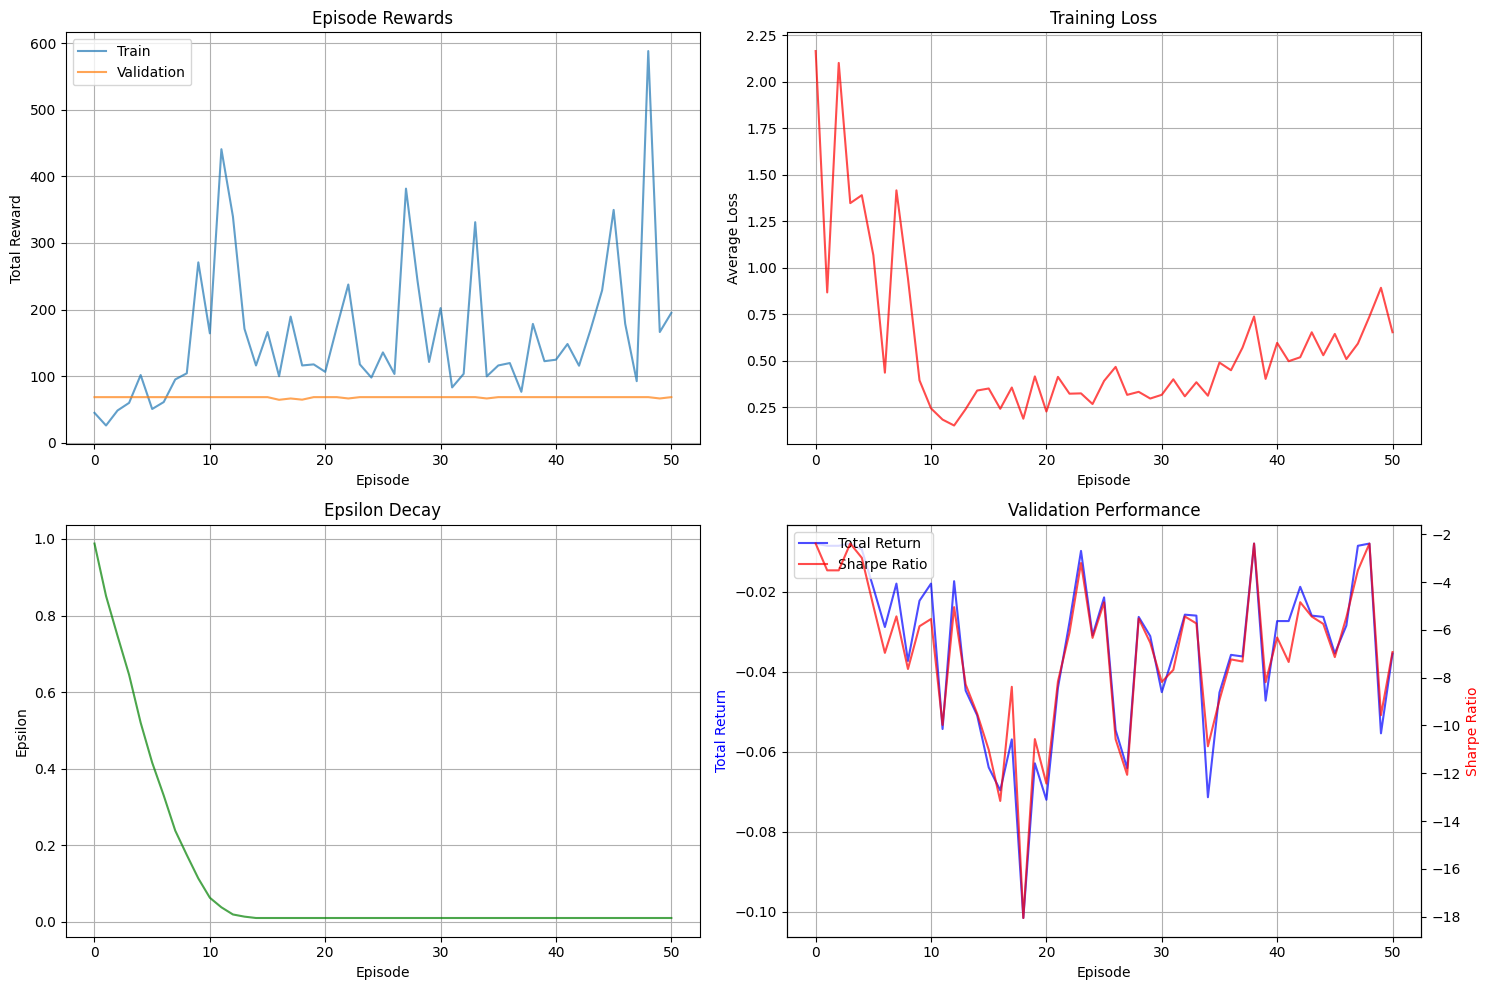


Starting backtesting...
Starting backtesting...

BACKTESTING RESULTS
Total Return: -10.66%
Sharpe Ratio: -2.92
Max Drawdown: 10.66%
Win Rate: 0.0%
Profit Factor: inf
Total Trades: 5
Final Equity: $8,933.60

Action Distribution:
  Action 4 (+100%): 6 times (2.0%)
  Action 2 (+0%): 286 times (94.4%)
  Action 3 (+50%): 6 times (2.0%)
  Action 0 (-100%): 5 times (1.7%)


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


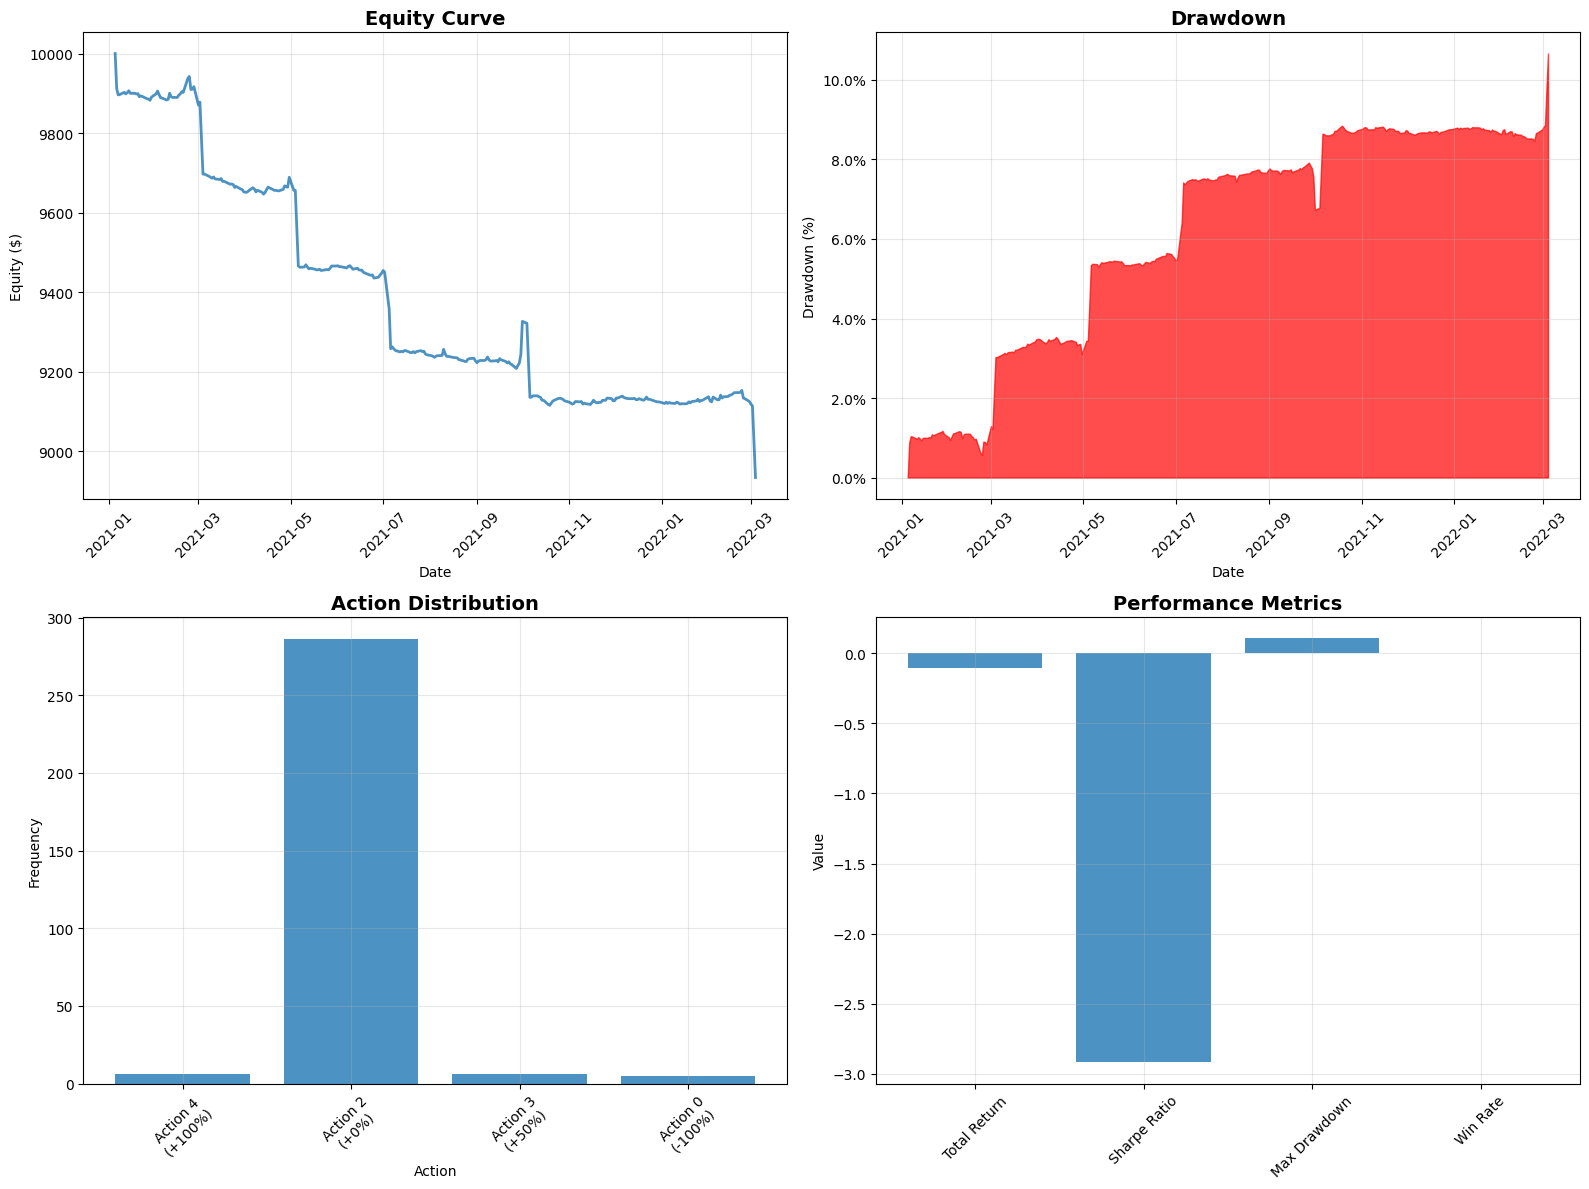


EXECUTION COMPLETED SUCCESSFULLY!
Training completed successfully!


In [8]:
# =============================================================================
# AUTO-EXECUTION FOR JUPYTER "RUN ALL"
# =============================================================================

if __name__ == "__main__":
    # CHANGE THIS PATH TO YOUR ACTUAL CSV FILE
    csv_file_path = "/notebooks/SB12 - Sheet1.csv"  # UPDATE THIS PATH!
    
    # Check if file exists
    if os.path.exists(csv_file_path):
        print(f"Found CSV file: {csv_file_path}")
        result = main(csv_file_path)
        if result[0] is not None:  # Check if training was successful
            agent, backtest_results, training_history = result
            print("Training completed successfully!")
        else:
            print("Training failed - check error messages above")
    #else:
     #   print(f"ERROR: CSV file not found at: {csv_file_path}")
      #  print("Please update the csv_file_path variable with the correct path to your data file")
       # print("Example: csv_file_path = '/path/to/your/data.csv'")